In [61]:
import torch
import torch.optim as optim
import torch.nn as nn
%load_ext autoreload
%autoreload 2
import model.dataset as ds
import model.models
import scipy.spatial.distance as ssdist
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.io.wavfile
from scipy.fftpack import dct
import scipy.signal
import IPython.display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
torch.cuda.empty_cache()

Loading the dataset

In [41]:
path = '/usr0/home/tianjunm/datasets/processed/mixer/a1/train';
d = ds.SignalDataset(root_dir=path, transform=ds.Concat(size=(129, 690)))
# d = ds.SignalDataset(root_dir=new, transform=ds.ToTensor(size=(129, 690)))

In [42]:
dataloader = torch.utils.data.DataLoader(d, batch_size=32, shuffle=False)

In [43]:
for i, info in enumerate(dataloader):
#     print(i)
    aggregate = info['aggregate']
    ground_truths = info['ground_truths']
    break
#     if i == 1: break

print(aggregate.shape)
print(ground_truths.shape)
# print(d[27*32])
# for i, info in enumerate(dataloader):
#     print(i)
#     if i==26:
#         print(info)

torch.Size([32, 690, 258])
torch.Size([32, 690, 2, 258])


In [44]:
def display(spect, sample_rate, y_axis='mel',x_axis='time'):
    db_data = librosa.power_to_db(np.abs(spect)**2, ref=np.max)
    librosa.display.specshow(db_data, sr=sample_rate, y_axis=y_axis, x_axis=x_axis)

torch.Size([32, 690, 258])


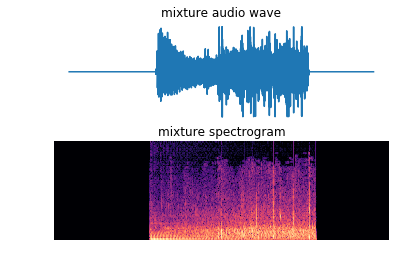

In [47]:
import numpy as np
print(aggregate.shape)

# print(torch.cat(list(aggregate.permute(1, 0, 2, 3)), -1).shape)

r = np.split(aggregate[1].numpy().T, 2)[0]
i = np.split(aggregate[1].numpy().T, 2)[1]

c = r + 1j * i
fs, data = scipy.signal.istft(c, fs=44100, nfft = 256)

plt.subplot(2, 1, 1)
plt.title('mixture audio wave')
plt.plot(data)
plt.axis('off')
plt.subplot(2, 1, 2)
plt.title('mixture spectrogram')
plt.axis('off')
display(c, 22050*8)

IPython.display.Audio(data=data, rate=44100)

In [48]:
import scipy.io.wavfile
from scipy.fftpack import dct
import scipy.signal
import IPython.display
import librosa
import librosa.display
import matplotlib.pyplot as plt

# _, rdata = scipy.signal.istft(c, fs=44100, nfft = 256)
# IPython.display.Audio(data=rdata, rate=44100)

transformer model

In [ ]:
import model.transformer
_, seq_len, freq_range = aggregate.shape
print(seq_len)
print(freq_range)
net = model.transformer.make_model(freq_range).to(device)

690
258


In [14]:
# net.eval()

In [52]:
from torch.autograd import Variable
subseq_mask = model.transformer.subsequent_mask(seq_len)
subseq_mask = Variable(subseq_mask).type_as(aggregate.data)

torch.Size([1, 690, 690])


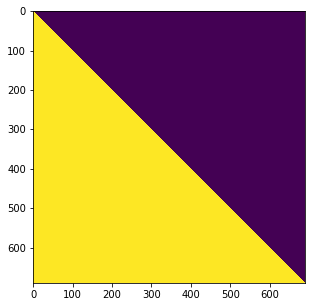

In [53]:
print(subseq_mask.shape)
plt.figure(figsize=(5,5))
plt.imshow(subseq_mask[0])

LSTM baselines

In [55]:
print(aggregate.size())
bs, seq_len, input_dim = aggregate.size()

# net = model.models.LookListen_Base(690, 129)

net = model.models.B1(input_dim=input_dim, seq_len=seq_len, num_sources=3)
# net2 = model.models.B1(input_dim, seq_len=seq_len, num_sources=2)


# net.load_state_dict(torch.load('pretrained_range10/B1_checkpoint_euclidean_3_245.pth'))
# net.eval()


# net2.load_state_dict(torch.load('pretrained_range10/B1_checkpoint_euclidean_0_490.pth'))
# net2.eval()

torch.Size([32, 690, 258])


In [58]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [59]:
# preds, _ = net(aggregate)
preds = net(aggregate, aggregate, None, subseq_mask)
print(preds.shape)
# preds2, _ = net2(aggregate)

RuntimeError: [enforce fail at CPUAllocator.cpp:56] posix_memalign(&data, gAlignment, nbytes) == 0. 12 vs 0


(0.0, 3.0040816326530613, 0.0, 11025.0)

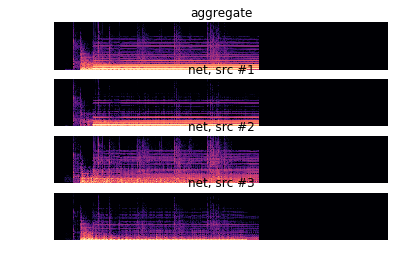

In [30]:
xid = 1
a = aggregate[xid]
g1 = preds[xid, :, 0, :].detach().numpy().T
g2 = preds[xid, :, 1, :].detach().numpy().T
g3 = preds[xid, :, 2, :].detach().numpy().T

# g1 = aggregate[0].numpy().T
r1 = np.split(g1, 2)[0]
i1 = np.split(g1, 2)[1]

c1 = r1 + 1j * i1

r2 = np.split(g2, 2)[0]
i2 = np.split(g2, 2)[1]

c2 = r2 + 1j * i2

r3 = np.split(g3, 2)[0]
i3 = np.split(g3, 2)[1]

c3 = r3 + 1j * i3

plt.subplot(4, 1, 1)
plt.title('aggregate')
display(c, 22050*8)
plt.axis('off')

plt.subplot(4, 1, 2)
plt.title('net, src #1')
display(c1, 22050*8)
plt.axis('off')

plt.subplot(4, 1, 3)
plt.title('net, src #2')
display(c2, 22050*8)
plt.axis('off')

plt.subplot(4, 1, 4)
plt.title('net, src #3')
display(c3, 22050*8)
plt.axis('off')

In [15]:
xid = 1
a = aggregate[xid]
g1 = preds2[xid, :, 0, :].detach().numpy().T
g2 = preds2[xid, :, 1, :].detach().numpy().T

# g1 = aggregate[0].numpy().T
r1 = np.split(g1, 2)[0]
i1 = np.split(g1, 2)[1]

c1 = r1 + 1j * i1

r2 = np.split(g2, 2)[0]
i2 = np.split(g2, 2)[1]

c2 = r2 + 1j * i2

plt.subplot(3, 1, 1)
plt.title('aggregate')
display(c, 22050*8)
plt.axis('off')

plt.subplot(3, 1, 2)
plt.title('net2, src #1')
display(c1, 22050*8)
plt.axis('off')

plt.subplot(3, 1, 3)
plt.title('net2, src #2')
display(c2, 22050*8)
plt.axis('off')

NameError: name 'preds2' is not defined

(0.0, 2.0027210884353743, 0.0, 11025.0)

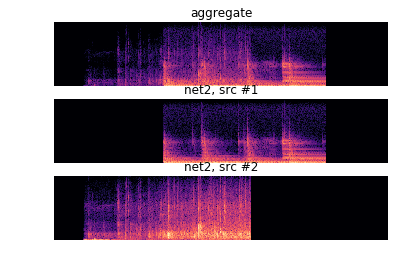

In [48]:
xid = 1
a = aggregate[xid]
g1 = ground_truths[xid, :, 0, :].detach().numpy().T
g2 = ground_truths[xid, :, 1, :].detach().numpy().T

# g1 = aggregate[0].numpy().T
r1 = np.split(g1, 2)[0]
i1 = np.split(g1, 2)[1]

c1 = r1 + 1j * i1

r2 = np.split(g2, 2)[0]
i2 = np.split(g2, 2)[1]

c2 = r2 + 1j * i2

plt.subplot(3, 1, 1)
plt.title('aggregate')
display(c, 22050*8)
plt.axis('off')

plt.subplot(3, 1, 2)
plt.title('net2, src #1')
display(c1, 22050*8)
plt.axis('off')

plt.subplot(3, 1, 3)
plt.title('net2, src #2')
display(c2, 22050*8)
plt.axis('off')

aggregate

In [31]:
_, data = scipy.signal.istft(c, fs=44100, nfft = 256)
IPython.display.Audio(data=data, rate=44100)

predicted separations

In [32]:
_, rdata = scipy.signal.istft(c1, fs=44100, nfft = 256)
IPython.display.Audio(data=rdata, rate=44100)

In [33]:
_, rdata = scipy.signal.istft(c2, fs=44100, nfft = 256)
IPython.display.Audio(data=rdata, rate=44100)

In [34]:
_, rdata = scipy.signal.istft(c3, fs=44100, nfft = 256)
IPython.display.Audio(data=rdata, rate=44100)

In [58]:
d = ds.SignalDataset(root_dir=new, transform=ds.ToTensor(size=(129, 690)))
dataloader = torch.utils.data.DataLoader(d, batch_size=32, shuffle=False)

In [59]:
for i, info in enumerate(dataloader):
#     print(i)
    aggregate = info['aggregate']
    ground_truths = info['ground_truths']
    break

In [62]:
bs, num_channels, seq_len, input_dim = aggregate.size()
net3 = model.models.LookListen_Base(input_dim=input_dim, seq_len=seq_len, num_sources=num_channels)

net3.load_state_dict(torch.load('pretrained_range10/google_checkpoint_euclidean_0_245.pth'))
net3.eval()

LookListen_Base(
  (convs): ModuleList(
    (0): Conv2d(2, 6, kernel_size=(1, 7), stride=(1, 1), padding=[0, 3])
    (1): Conv2d(6, 6, kernel_size=(7, 1), stride=(1, 1), padding=[3, 0])
    (2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2])
    (3): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=[4, 4], dilation=(2, 2))
    (4): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=[8, 8], dilation=(4, 4))
    (5): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=[16, 16], dilation=(8, 8))
    (6): Conv2d(6, 8, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2])
  )
  (bns): ModuleList(
    (0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2

In [63]:
preds3, _ = net3(aggregate)

(0.0, 2.0027210884353743, 0.0, 11025.0)

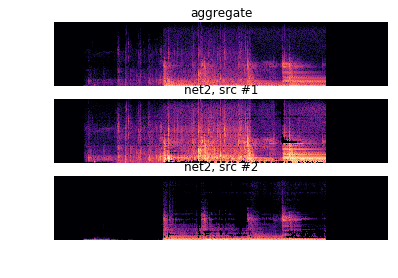

In [64]:
xid = 1
a = aggregate[xid]
g1 = preds3[xid, :, 0, :].detach().numpy().T
g2 = preds3[xid, :, 1, :].detach().numpy().T

# g1 = aggregate[0].numpy().T
r1 = np.split(g1, 2)[0]
i1 = np.split(g1, 2)[1]

c1 = r1 + 1j * i1

r2 = np.split(g2, 2)[0]
i2 = np.split(g2, 2)[1]

c2 = r2 + 1j * i2

plt.subplot(3, 1, 1)
plt.title('aggregate')
display(c, 22050*8)
plt.axis('off')

plt.subplot(3, 1, 2)
plt.title('net2, src #1')
display(c1, 22050*8)
plt.axis('off')

plt.subplot(3, 1, 3)
plt.title('net2, src #2')
display(c2, 22050*8)
plt.axis('off')

In [35]:
criterion = model.models.MinLoss(device, metric='euclidean')

In [36]:
loss = criterion(preds, ground_truths)
loss

tensor(92630.7422, device='cuda:0', grad_fn=<DivBackward0>)

In [40]:
loss2 = criterion(preds2, ground_truths)
loss2

tensor(285516.1250, device='cuda:0', grad_fn=<SumBackward0>)

In [62]:
loss.backward()

In [63]:
loss2.backward()

In [64]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer.step()
# preds2 = net(aggregate)

In [69]:
opt2= optim.SGD(net2.parameters(), lr=0.01, momentum=0.9)
opt2.step()

tensor(461107.5000, grad_fn=<SumBackward0>)

In [16]:
print(len(ground_truths))
print(ground_truths[0].size())
gt = net.reshape(ground_truths[0])
print(torch.squeeze(gt[:, 0, :], dim=1).size())

2
torch.Size([32, 173, 1025])
torch.Size([173, 1025])


In [6]:
# print(aggregate[:, 0])
# agg = torch.t(aggregate)
# print(agg[0, :])
print(aggregate.size())
print(aggregate[1, 1, :])
seq_len = aggregate.size()[1]
aggs = [aggregate[:, t, :] for t in range(seq_len)]
x = torch.cat(aggs).view(173, bs, -1)
print(x[1, 1, :])
print(x.size())

torch.Size([32, 173, 1025])
tensor([1.4197e-19, 9.8981e-19, 1.4690e-17,  ..., 8.6916e-19, 1.9786e-18,
        1.6256e-18])
tensor([1.4197e-19, 9.8981e-19, 1.4690e-17,  ..., 8.6916e-19, 1.9786e-18,
        1.6256e-18])
torch.Size([173, 32, 1025])


In [81]:
# from scipy.spatial import distance
a = np.arange(15).reshape(3,5)
b = np.random.randint(5, size=(3, 5))
# print(a)
# print(b)
# a.reshape(1, 5) - b.reshape(5, 1)

# distance.cdist(a, b)

# a.flatten()


t = torch.arange(24).view(2, 3, -1)

print(t)
print(t[:, 0, :])
print(t[:, 0, :].numpy().flatten())

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],

        [[12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23]]])
tensor([[ 0,  1,  2,  3],
        [12, 13, 14, 15]])
[ 0  1  2  3 12 13 14 15]


In [31]:

def check(m_c, m):
    for i in range(m_c.shape[0]):
        for j in range(m_c.shape[1]):
            batch = i // m.shape[1]
            ii = i % m.shape[1]
            assert(m_c[i][j] == m[batch][ii][j])
    print("passed")

check(agg_concat, agg)

passed
